# Converting a floor plan image to wall lines and openings

In [5]:
import cv2
import matplotlib.pyplot as plt

IMG_1_PATH = "./img/example_1.png"
IMG_2_PATH = "./img/example_2.jpg"

Let's take two example floor plan images.

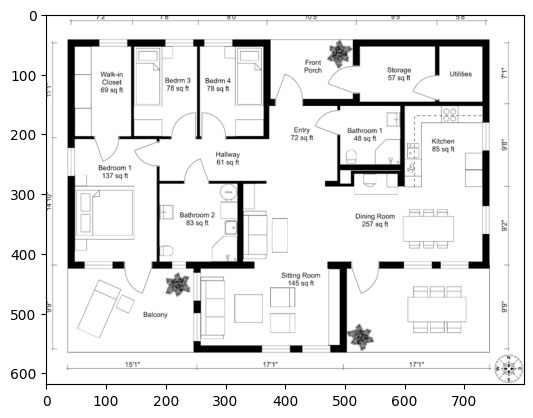

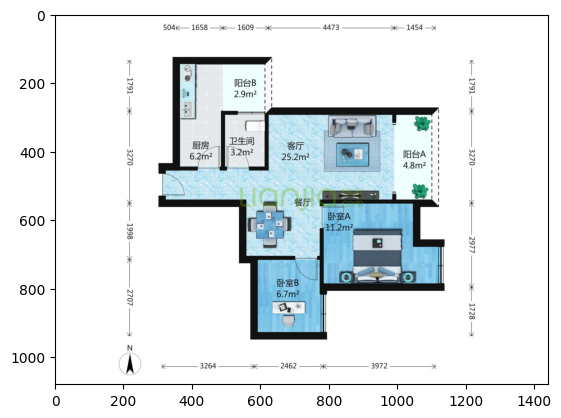

In [98]:
def display_img(path: str):
    img = cv2.imread(path)
    plt.imshow(img)
    plt.show()
    return img

img_1 = display_img(IMG_1_PATH)
img_2 = display_img(IMG_2_PATH)


## Remove text

Remove text artifacts from the picture. Detect text with OCR using a neural network, then inpaint the text position. 

As a general guideline, this is the sign that a trained neural network model and inpainting techniques can be used to standardize the floor plan images. 

In [16]:
import keras_ocr
import numpy as np
import math

In [19]:
def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2) / 2)
    y_mid = int((y1 + y2) / 2)
    return (x_mid, y_mid)

def inpaint_text(img_path: str, pipeline: keras_ocr.pipeline.Pipeline):
    # read image
    img = keras_ocr.tools.read(img_path)
    # generate (word, box) tuples
    prediction_groups = pipeline.recognize([img])

    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1]
        x2, y2 = box[1][2]
        x3, y3 = box[1][3]

        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)

        thickness = int(math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2))

        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255, thickness)
        # CV2 inpainting
        img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)

    return img

ocr_pipeline = keras_ocr.pipeline.Pipeline()

Looking for /Users/Nicolas_Oulianov/.keras-ocr/craft_mlt_25k.h5


2023-06-24 16:09:33.231196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-24 16:09:33.232567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-24 16:09:33.233478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Looking for /Users/Nicolas_Oulianov/.keras-ocr/crnn_kurapan.h5


In [20]:
img_1_without_text = inpaint_text(IMG_1_PATH, ocr_pipeline)
img_2_without_text = inpaint_text(IMG_2_PATH, ocr_pipeline)

1/1 [==============================] - 7s 7s/step


2023-06-24 16:09:42.148505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-24 16:09:42.149732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-24 16:09:42.150751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 2s 228ms/step


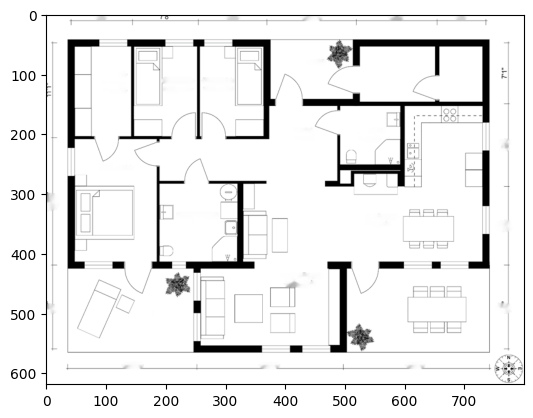

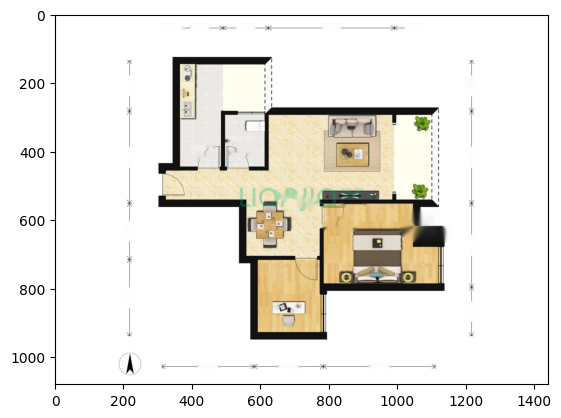

In [22]:
plt.imshow(img_1_without_text)
plt.show()

plt.imshow(img_2_without_text)
plt.show()

## Preprocess for edge detection

We're gonna use an edge detection algorithm to capture the geometry behind the thick, black lines that represent the walls. 

We want an image in black and white with mostly those walls. 

In [95]:
def preprocess_image(img):
    # Grayscale and 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Remove details and noise with blur
    kernel_size = 5
    blur = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
    # Black and white to keep mostly the black
    _, thresh = cv2.threshold(blur, 30, 255, cv2.THRESH_BINARY)
    
    # Make the black walls white (more idiomatic in contour detection)
    thresh = 255 - thresh

    # inflate to group small clusters of pixels
    thresh = cv2.dilate(thresh, np.ones((8, 8), np.uint8), iterations=2)
    
    # Erode to remove small lines
    thresh = cv2.erode(thresh, np.ones((8, 8), np.uint8), iterations=1)

    return thresh

preprocessed_img_1 = preprocess_image(img_1_without_text)
preprocessed_img_2 = preprocess_image(img_2_without_text)

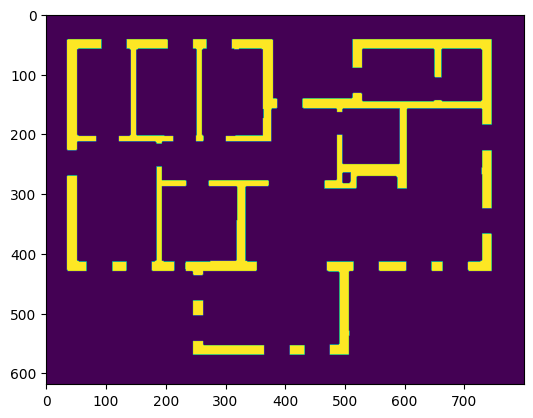

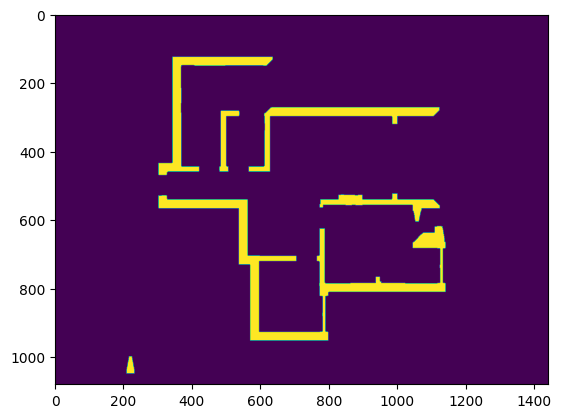

In [96]:
plt.imshow(preprocessed_img_1)
plt.show()

plt.imshow(preprocessed_img_2)
plt.show()

Preprocessing is not perfect.
- Removes windows
- Only works with thick black walls
- interprets some dark objects as walls

How to improve :
- Better detect zone of interest to be cropped (ex: to remove exterior lines and symbols)
- Better preprocessing with neural network to remove objects 
- Downstream improvements to find rectangles and fill the missing walls 
- UX improvement to make those issues easy to deal with

## Detect geometry

Our taks of detecting walls and doors is similar to edge or contour detection.

We also want to transform the plan into a vectorized format. 

In [179]:
def draw_contours(contour, background_img):
    drawn_img = background_img.copy()
    cv2.drawContours(drawn_img, [contour], 0, (255, 0, 255), 5)
    return drawn_img

## Detect individual shapes

Each separate thick black wall becomes a single shape. 

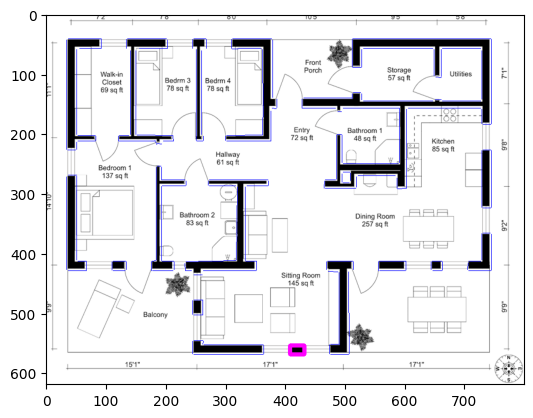

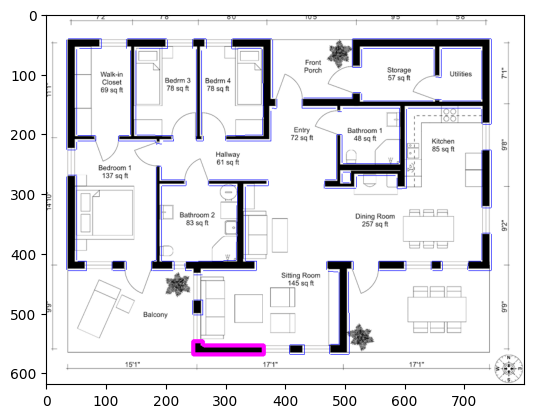

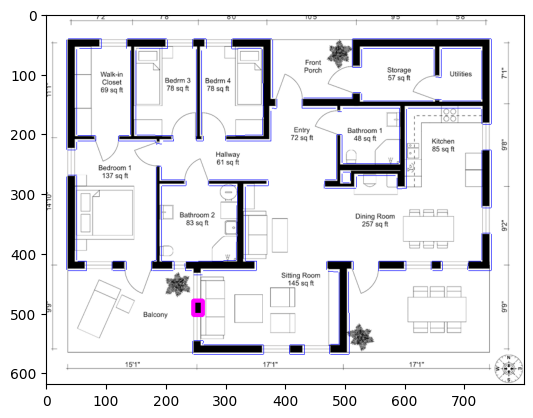

In [181]:
contours_1, _ = cv2.findContours(preprocessed_img_1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_2, _ = cv2.findContours(preprocessed_img_2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Example for 3 detected pieces
for c in contours_1[:3]: 
    drawn_img = draw_contours(c, img_1)
    plt.imshow(drawn_img)
    plt.show()

### Partition shapes

We have found complex shapes that we want to simplify. We want to find the minimum sets of rectangles that cover each binary images. 

![image.png](rectangle_partition.png)

We use this algorithm for [rectilinear partition](https://github.com/mittalgovind/Polygon-Partition)


In [194]:
import min_partition

SyntaxError: invalid syntax (1047103934.py, line 1)

In [196]:
import os 
os.getcwd()

'/Users/Nicolas_Oulianov/plan2svg'